Instalando bibliotecas necessárias para análise do grafo.

In [ ]:
!pip install osmnx

Agora, gerando o grafo de Blumenau, cidade escolhida pela equipe para realizar o trabalho.

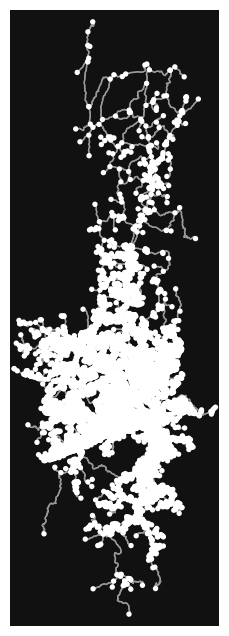

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
import networkx as nx
import osmnx as ox

G: nx.MultiDiGraph = ox.graph_from_place(
    'Blumenau, Brazil',
    network_type='drive'
)

ox.plot_graph(G)

Adicionando os vértices que representam cada aluno. Foram utilizados *pontos de referência próximos às residências* de cada aluno para não comprometer informações pessoais.

In [ ]:
# ALUNOS = {
#     'lemuel': ( -26.902199, -49.134537 ),
#     'lucas':  ( -26.911738, -49.080724 )
# }

# def add_all(G: nx.MultiDiGraph, locale: dict[str, tuple[float, float]]):
#   for name, pos in locale.items():
#     G.add_node(name, x=pos[1], y=pos[0])

# add_all(G, ALUNOS)

print(G.nodes[ox.distance.nearest_nodes(G, X=-49.080724, Y=-26.911738)])

{'y': -27.0573693, 'x': -49.0862424, 'street_count': 1}
{'y': -26.882776, 'x': -49.15353, 'street_count': 3}
{'y': -26.9121662, 'x': -49.0800868, 'street_count': 4}
